In [1]:
import pandas as pd
import torch
import transformers
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [36]:
data = pd.read_csv('/content/drive/MyDrive/imdb_data_cleaned.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49577,I thought this movie did a down right good job...,1
49578,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49579,I am a Catholic taught in parochial elementary...,0
49580,I'm going to have to disagree with the previou...,0


In [37]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4

LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [38]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.review
        self.targets = self.data.sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [39]:
train_size = 0.8
train_data = data.sample(frac=train_size,random_state=200)
test_data = data.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (49582, 2)
TRAIN Dataset: (39666, 2)
TEST Dataset: (9916, 2)


In [40]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [41]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [42]:
model = RobertaClass()
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [43]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [44]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [45]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return epoch_accu, epoch_loss

In [46]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu, epoch_loss


In [47]:
import copy
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

EPOCHS     = 4
PATIENCE   = 1
MONITOR    = "val_loss"
MODE       = "min"

best_metric   = float("inf") if MODE == "min" else -float("inf")
patience_cnt  = 0
best_weights  = None

for ep in range(EPOCHS):
    tr_acc, tr_loss = train(ep)
    val_acc, val_loss = valid(model, testing_loader)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)

    print(f"Epoch {ep} done ✓")

    current = val_loss if MONITOR == "val_loss" else val_acc
    better  = (current < best_metric) if MODE == "min" else (current > best_metric)

    if better:
        best_metric  = current
        patience_cnt = 0
        best_weights = copy.deepcopy(model.state_dict())
    else:
        patience_cnt += 1

        if patience_cnt >= PATIENCE:
            print("Early stopping triggered")
            break
if best_weights is not None:
    model.load_state_dict(best_weights)
    print(f"Model: best weights protected -> ({MONITOR}={best_metric:.4f})")


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.708359956741333
Training Accuracy per 5000 steps: 37.5


4959it [30:24,  2.72it/s]


The Total Accuracy for Epoch 0: 91.93767962486764
Training Loss Epoch: 0.20536924219603123
Training Accuracy Epoch: 91.93767962486764


1it [00:00,  8.39it/s]

Validation Loss per 100 steps: 0.5761903524398804
Validation Accuracy per 100 steps: 75.0


2479it [02:31, 16.31it/s]


Validation Loss Epoch: 0.15956571337695752
Validation Accuracy Epoch: 94.1206131504639
Epoch 0 done ✓


1it [00:00,  6.10it/s]

Training Loss per 5000 steps: 0.05775928869843483
Training Accuracy per 5000 steps: 100.0


4959it [30:23,  2.72it/s]


The Total Accuracy for Epoch 1: 95.27555084959411
Training Loss Epoch: 0.13091914657941703
Training Accuracy Epoch: 95.27555084959411


1it [00:00,  9.37it/s]

Validation Loss per 100 steps: 0.0034266584552824497
Validation Accuracy per 100 steps: 100.0


2479it [02:31, 16.34it/s]

Validation Loss Epoch: 0.17231367026281852
Validation Accuracy Epoch: 93.87858007260992
Epoch 1 done ✓
Early stopping triggered
Model: best weights protected -> (val_loss=0.1596)


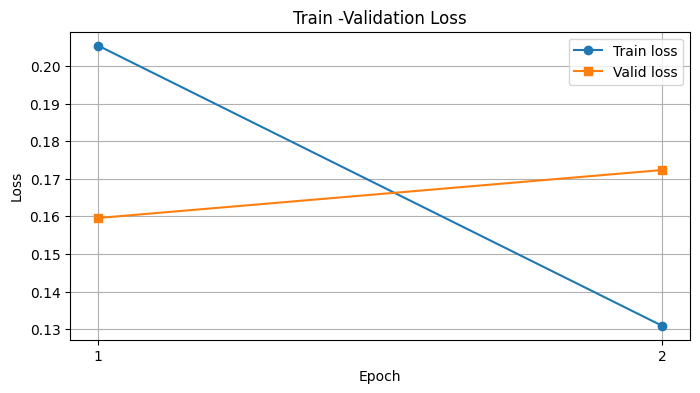

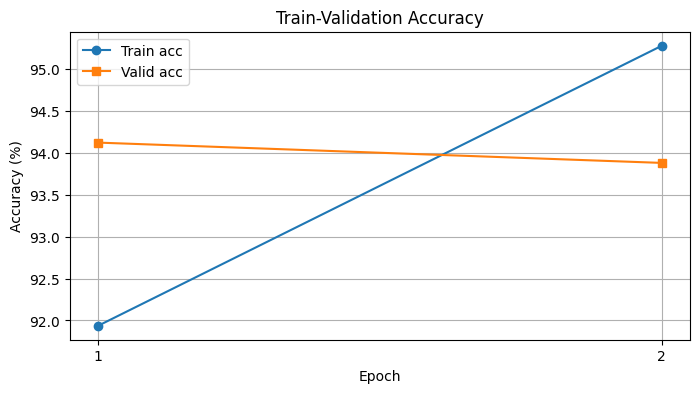

In [53]:
import matplotlib.pyplot as plt

epochs = range(1,3)

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_losses, marker='o', label='Train loss')
plt.plot(epochs, val_losses,   marker='s', label='Valid loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Train -Validation Loss')
plt.xticks(epochs)
plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, train_accs, marker='o', label='Train acc')
plt.plot(epochs, val_accs,   marker='s', label='Valid acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
plt.title('Train-Validation Accuracy')
plt.xticks(epochs)
plt.grid(True); plt.legend()
plt.show()

In [57]:
def predict_reviews(reviews):

    if isinstance(reviews, str):
        reviews = [reviews]

    model.eval()
    device_ = next(model.parameters()).device

    results = []
    with torch.no_grad():
        enc = tokenizer(
            reviews,
            padding=True,
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        ).to(device_)

        logits = model(enc["input_ids"], enc["attention_mask"])
        probs  = torch.softmax(logits, dim=-1)
        preds  = probs.argmax(dim=-1).cpu().numpy()

        for idx, review in enumerate(reviews):
            label = "POSITIVE" if preds[idx] == 1 else "NEGATIVE"
            score = probs[idx, preds[idx]].item()
            results.append({"label": label, "score": round(score, 3)})

    return results

samples = [
    "The movie was surprisingly touching and well-acted.",
    "Plot holes everywhere—what a waste of time!",
    "I fell asleep halfway through.",
    "Amazing cinematography but weak story.",
    """i'll spare you the "cinema is dead" spiel and instead elect to mention that they literally say "epic fail" like five times in this movie""", #1/5-star
    "i have no clue what the plot of this was supposed to be, but one star because the scene of ryan in the car reminiscing about his ex while listening to all too well i fear i may know that feeling a little bit all too well.", # 1/5-star
    "they added the scene where colt cries in the car while listening to all too well by taylor swift so that girls could have their own “literally me” ryan gosling moment", #4/5-star
    "the fall guy was released in dvd/bluray format today so I had to watch it again and I know what you all will say regarding the amount of times I’ve seen this film but how could I just ignore watching it on my own new physical copy when it came in the mail today… I couldn’t, bc my love for this film is too strong", #5-star
    "A clear thank-you message to stunt performers, and all those in a craft that frequently receives less recognition than it deserves, but a film that is messy—really messy. Gosling and Blunt try their hardest to lift the weak writing, and they occasionally succeed in providing ounces of charisma and charm, but their fundamental relationship felt deeply forced. It's an effort that unfortunately falls into many of the modern-day blockbuster traps—meta humour that lands less than it should and okay-ish action sequences that feel way too long (as does the entire film). There is true enthusiasm there, and don't get me wrong, there are some genuinely pretty funny and heartfelt moments (especially the ones with Gosling leading the line), but I can't help but feel slightly disappointed overall." #2,5/5 star
]

for out in predict_reviews(samples):
    print(out)


{'label': 'POSITIVE', 'score': 0.997}
{'label': 'NEGATIVE', 'score': 0.996}
{'label': 'NEGATIVE', 'score': 0.849}
{'label': 'NEGATIVE', 'score': 0.739}
{'label': 'NEGATIVE', 'score': 0.925}
{'label': 'NEGATIVE', 'score': 0.732}
{'label': 'POSITIVE', 'score': 0.514}
{'label': 'POSITIVE', 'score': 0.997}
{'label': 'NEGATIVE', 'score': 0.947}


In [51]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_weights.pth')